In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
from liualgotrader.analytics import analysis 
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys
import pytz

In [2]:
day_to_analyze = datetime.strptime("2020-10-12", "%Y-%m-%d")

In [3]:
trades = analysis.load_trades(day_to_analyze)

In [4]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price,expire_tstamp,batch_id
0,43217,4964,ACEL,buy,64,11.27,"{'buy': {'avg': 11.1004, 'macd': [0.0664504201...",2020-10-12 14:05:56.548720+00:00,2020-10-12 14:05:56.794143,10.71,13.06,None,6de7b192-21e0-4c8e-8e7a-5b08a7427bd9
1,43218,4964,ACEL,buy,96,11.27,"{'buy': {'avg': 11.1004, 'macd': [0.0664504201...",2020-10-12 14:05:56.651796+00:00,2020-10-12 14:05:56.977954,10.71,13.06,None,6de7b192-21e0-4c8e-8e7a-5b08a7427bd9
2,43278,4964,ACEL,sell,160,11.22,"{'buy': None, 'sell': {'liquidation': 1}}",2020-10-12 19:46:14.280955+00:00,2020-10-12 19:47:24.221495,10.71,13.06,None,6de7b192-21e0-4c8e-8e7a-5b08a7427bd9
3,43253,4964,APHA,buy,512,6.26,"{'buy': {'avg': 6.1042, 'macd': [0.00431355209...",2020-10-12 15:26:24.537743+00:00,2020-10-12 15:26:24.929116,6.08,6.82,None,6de7b192-21e0-4c8e-8e7a-5b08a7427bd9
4,43261,4964,APHA,sell,512,6.38,"{'buy': None, 'sell': {'avg': 6.1438, 'rsi': [...",2020-10-12 15:43:40.442585+00:00,2020-10-12 15:43:40.867980,6.08,6.82,None,6de7b192-21e0-4c8e-8e7a-5b08a7427bd9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,43269,4960,UBX,sell,853,4.10,"{'buy': None, 'sell': {'avg': 3.9951, 'rsi': [...",2020-10-12 16:21:28.285923+00:00,2020-10-12 16:22:42.158695,3.91,4.35,None,6de7b192-21e0-4c8e-8e7a-5b08a7427bd9
68,43257,4964,VNE,buy,210,18.40,"{'buy': {'avg': 18.3018, 'macd': [-0.002271087...",2020-10-12 15:30:11.725964+00:00,2020-10-12 15:30:12.008994,17.95,19.74,None,6de7b192-21e0-4c8e-8e7a-5b08a7427bd9
69,43279,4964,VNE,sell,210,18.33,"{'buy': None, 'sell': {'liquidation': 1}}",2020-10-12 19:46:45.280559+00:00,2020-10-12 19:47:56.216024,17.95,19.74,None,6de7b192-21e0-4c8e-8e7a-5b08a7427bd9
70,43235,4964,WVE,buy,315,8.96,"{'buy': {'avg': 8.7536, 'macd': [0.01931350679...",2020-10-12 15:04:14.314996+00:00,2020-10-12 15:04:14.678764,8.66,9.86,None,6de7b192-21e0-4c8e-8e7a-5b08a7427bd9


In [5]:
algo_runs = analysis.load_runs(day_to_analyze)

In [29]:
symbol_name = []
counts = []
revenues = []
est = pytz.timezone("US/Eastern")
batch_ids = trades.batch_id.unique().tolist()
batch_ids.reverse()

current_max = pd.options.display.max_rows
pd.set_option("display.max_rows", None)
for batch_id in batch_ids :
    how_was_my_day = pd.DataFrame()
    how_was_my_day["symbol"] = trades.loc[trades["batch_id"] == batch_id][
        "symbol"
    ].unique()
    how_was_my_day["revenues"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.calc_revenue(x, trades)
    )
    how_was_my_day["count"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.count_trades(x, trades)
    )

    batch_time = algo_runs.loc[algo_runs["batch_id"] == batch_id].start_time.min().tz_localize("utc").astimezone(est)
    print(
        f"{batch_id} {batch_time} total revenues=${round(sum(how_was_my_day['revenues']),2)}"
    )
    display(how_was_my_day)

pd.set_option("display.max_rows", current_max)

aa43ef5c-07e8-4a96-bbb6-2dcbea319fe5 2020-10-12 09:30:04.538563-04:00 total revenues=$209.24


,symbol,revenues,count
0,CGC,30.78,2
1,FPRX,10.36,2
2,HYRE,18.52,3
3,INTZ,20.15,2
4,MARA,11.04,2
5,PRTY,69.52,2
6,RIOT,48.87,2


6de7b192-21e0-4c8e-8e7a-5b08a7427bd9 2020-10-12 11:00:19.590921-04:00 total revenues=$-263.73


,symbol,revenues,count
0,ACEL,-8.00,3
1,APHA,61.44,2
2,ATHA,-86.92,2
3,EBR,-38.61,2
4,EOLS,-16.85,2
5,FLUX,-101.64,2
6,FRAN,-58.14,2
7,FTK,37.32,2
8,GME,-95.15,2
9,GPRO,31.22,2


In [7]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
minute_history = {}
for symbol in trades.symbol.unique().tolist():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol,
        1,
        "minute",
        _from=str((day_to_analyze - timedelta(days=10)).date()),
        to=str((day_to_analyze + timedelta(days=1)).date()),
    ).df

ACEL analysis with profit $-8.0


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-721.28,-721.28,buy,2020-10-12 10:05:56.794143-04:00,11.27,64,2.83%,,"{'buy': {'avg': 11.1004, 'macd': [0.0664504201306535, 0.07225059061062566, 0.07597151516774758, 0.08041415959093179, 0.08537162562515377], 'vwap': 11.2903, 'macd_signal': [0.07009587326677809, 0.0705268167355476, 0.0716157564219876, 0.07337543705577644, 0.07577467476965191]}, 'sell': None}",13.06,10.71
1,-1803.20,-1081.92,buy,2020-10-12 10:05:56.977954-04:00,11.27,96,2.83%,,"{'buy': {'avg': 11.1004, 'macd': [0.0664504201306535, 0.07225059061062566, 0.07597151516774758, 0.08041415959093179, 0.08537162562515377], 'vwap': 11.2903, 'macd_signal': [0.07009587326677809, 0.0705268167355476, 0.0716157564219876, 0.07337543705577644, 0.07577467476965191]}, 'sell': None}",13.06,10.71
2,-8.00,1795.20,sell,2020-10-12 15:47:24.221495-04:00,11.22,160,2.37%,,"{'buy': None, 'sell': {'liquidation': 1}}",13.06,10.71


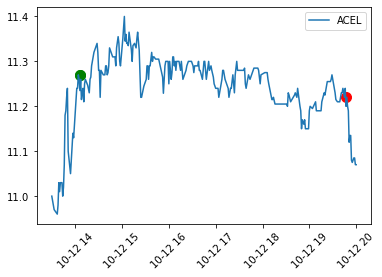

APHA analysis with profit $61.44


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3205.12,-3205.12,buy,2020-10-12 11:26:24.929116-04:00,6.26,512,4.66%,,"{'buy': {'avg': 6.1042, 'macd': [0.004313552097985784, 0.0029884995884801313, 0.0023151564589420914, 0.0037635040758683402, 0.006331143900230707], 'vwap': 6.2686, 'macd_signal': [0.007891684568486245, 0.006911047572485023, 0.0059918693497764365, 0.005546196294994817, 0.005703185816041996]}, 'sell': None}",6.82,6.08
1,61.44,3266.56,sell,2020-10-12 11:43:40.867980-04:00,6.38,512,6.67%,,"{'buy': None, 'sell': {'avg': 6.1438, 'rsi': [69.52183544263451, 58.55528693028644, 61.32435419497423], 'vwap': 6.3879, 'reasons': 'bail', 'movement': 0.02043130990415341, 'sell_macd': [0.026412537178527984, 0.025231203442132255, 0.025281706979457752, 0.02300831094387501, 0.021774387916877025], 'sell_macd_signal': [0.022873472965767572, 0.023345019061040508, 0.023732356644723958, 0.02358754750455417, 0.02322491558701874]}}",6.82,6.08


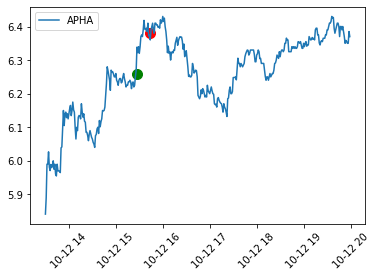

ATHA analysis with profit $-86.92


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2874.92,-2874.92,buy,2020-10-12 11:14:55.761527-04:00,17.53,164,3.73%,,"{'buy': {'avg': 17.3882, 'macd': [0.005638334067000983, 0.0005947263759331634, 0.020568028311693354, 0.02561186283900696, 0.03326031595483414], 'vwap': 17.6248, 'macd_signal': [0.013854652069601004, 0.011202666930867435, 0.01307573920703262, 0.015582963933427488, 0.01911843433770882]}, 'sell': None}",19.34,17.05
1,-86.92,2788.00,sell,2020-10-12 11:30:44.865837-04:00,17.00,164,0.59%,,"{'buy': None, 'sell': {'avg': 17.3896, 'rsi': [38.86526895318433, 37.75270494750597, 31.635192068144573], 'vwap': 17.02, 'reasons': 'stopped', 'movement': -0.029092983456931062, 'sell_macd': [-0.006458894512423541, -0.01648214473591736, -0.025584909264146916, -0.03377427241258246, -0.048678006393018336], 'sell_macd_signal': [5.264623604736476e-05, -0.00325431195834558, -0.007720431419505847, -0.01293119961812117, -0.020080560973100604]}}",19.34,17.05


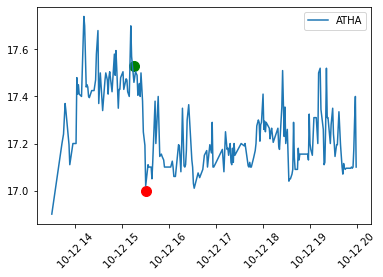

CGC analysis with profit $30.78


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1570.59,-1570.59,buy,2020-10-12 10:03:36.246148-04:00,19.39,81,3.19%,,"{'buy': {'avg': 18.8051, 'macd': [0.1475731087751555, 0.15961189777547347, 0.1628056851942361, 0.17436542536341904, 0.18274339358299585], 'vwap': 19.3861, 'macd_signal': [0.14450012984114002, 0.14752248342800672, 0.1505791237812526, 0.15533638409768588, 0.16081778599474789]}, 'sell': None}",22.85,18.24
1,30.78,1601.37,sell,2020-10-12 10:43:11.713234-04:00,19.77,81,5.21%,,"{'buy': None, 'sell': {'avg': 19.2324, 'rsi': [60.009294594646626, 54.4339695171575, 55.0760890396997], 'vwap': 19.7787, 'reasons': 'bail', 'movement': 0.02011346054667357, 'sell_macd': [0.06416435506205431, 0.06513482290469241, 0.062447722224867164, 0.05521559543247534, 0.04941373565356244], 'sell_macd_signal': [0.05140292561283737, 0.05414930507120838, 0.05580898850194014, 0.05569030988804718, 0.05443499504115023]}}",22.85,18.24


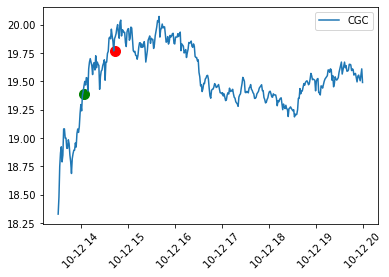

EBR analysis with profit $-38.61


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2070.90,-2070.90,buy,2020-10-12 11:24:35.249348-04:00,5.90,351,4.24%,,"{'buy': {'avg': 5.8004, 'macd': [0.000737541431220734, 0.018589903491259108, 0.02239343611959388, 0.026314797168921267, 0.031480367254075325], 'vwap': 5.9, 'macd_signal': [0.0008278891414730823, 0.004380292011430287, 0.007982920833063005, 0.011649296100234657, 0.01561551033100279]}, 'sell': None}",6.7,5.63
1,-38.61,2032.29,sell,2020-10-12 15:46:41.288443-04:00,5.79,351,2.3%,,"{'buy': None, 'sell': {'liquidation': 1}}",6.7,5.63


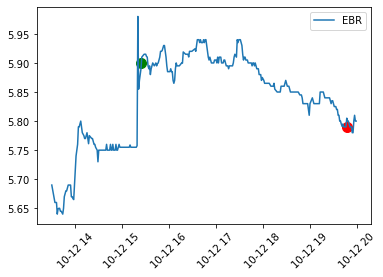

EOLS analysis with profit $-16.85


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1610.86,-1610.86,buy,2020-10-12 09:57:18.535786-04:00,4.78,337,1.06%,,"{'buy': {'avg': 4.6251, 'macd': [0.024063861729229252, 0.029766375644789456, 0.03403852899008797, 0.03924732686472243, 0.04402974882502342], 'vwap': 4.7444, 'macd_signal': [0.021082505253009497, 0.02281927933136549, 0.025063129263109985, 0.027899968783432476, 0.031125924791750664]}, 'sell': None}",5.58,4.47
1,-16.85,1594.01,sell,2020-10-12 15:46:48.218678-04:00,4.73,337,0.0%,,"{'buy': None, 'sell': {'liquidation': 1}}",5.58,4.47


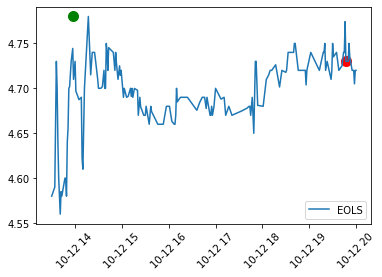

FLUX analysis with profit $-101.64


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1242.67,-1242.67,buy,2020-10-12 10:20:45.029018-04:00,10.27,121,8.91%,,"{'buy': {'avg': 9.853, 'macd': [0.09081362746688271, 0.09140111332697387, 0.10916736448998776, 0.12184271950955683, 0.13362377863304076], 'vwap': 10.2853, 'macd_signal': [0.10836658757705361, 0.10497349272703767, 0.10581226707962768, 0.10901835756561351, 0.11393944177909895]}, 'sell': None}",12.6,9.49
1,-101.64,1141.03,sell,2020-10-12 11:07:56.133743-04:00,9.43,121,0.0%,,"{'buy': None, 'sell': {'avg': 9.9169, 'rsi': [27.295066502238853, 27.138189786943535, 24.21279939151601], 'vwap': 9.461, 'reasons': 'stopped', 'movement': -0.07863680623174285, 'sell_macd': [-0.027452765660907374, -0.0357148756283987, -0.05207866423127072, -0.06441306230842692, -0.07833060545545223], 'sell_macd_signal': [-0.008251734263630581, -0.013744362536584205, -0.02141122287552151, -0.030011590762102594, -0.03967539370077252]}}",12.6,9.49


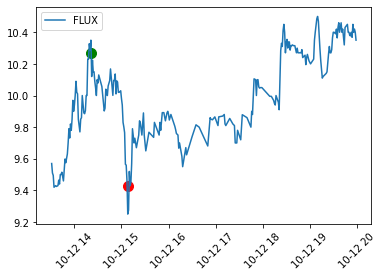

FPRX analysis with profit $10.36


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1465.94,-1465.94,buy,2020-10-12 09:53:10.934145-04:00,5.66,259,1.86%,,"{'buy': {'avg': 5.5268, 'macd': [0.022585430393850636, 0.026968187137452304, 0.030836521484862267, 0.03596485726719312, 0.04196609063207113], 'vwap': 5.66, 'macd_signal': [0.01187202857919199, 0.014891260290844052, 0.018080312529647695, 0.02165722147715678, 0.02571899530813965]}, 'sell': None}",6.75,5.3
1,10.36,1476.30,sell,2020-10-12 10:23:25.981243-04:00,5.70,259,2.58%,,"{'buy': None, 'sell': {'avg': 5.5878, 'rsi': [59.84480910892061, 54.3423653045697, 54.3423653045697], 'vwap': 5.7, 'reasons': 'bail post whipsawed', 'movement': 0.007067137809187285, 'sell_macd': [0.0419823275859299, 0.0420420352483708, 0.040243858943150634, 0.03572263248527641, 0.031735668589721655], 'sell_macd_signal': [0.031217717793556515, 0.033382581284519375, 0.034754836816245624, 0.03494839595005178, 0.034305850477985754]}}",6.75,5.3


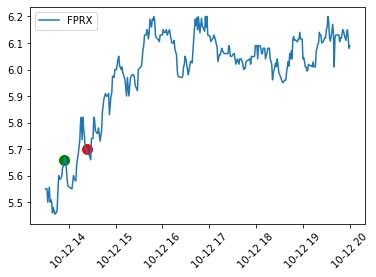

FRAN analysis with profit $-58.14


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1125.18,-1125.18,buy,2020-10-12 11:00:50.106531-04:00,3.29,342,11.9%,,"{'buy': {'avg': 3.345, 'macd': [-0.01890736158306483, -0.014719073486474166, -0.010543986533459115, -0.0038900695584933587, 0.005356048522274559], 'vwap': 3.2831, 'macd_signal': [-0.03188591713455767, -0.02845254840494097, -0.0248708360306446, -0.02067468273621435, -0.015468536484516567]}, 'sell': None}",4.12,3.01
1,-58.14,1067.04,sell,2020-10-12 14:42:19.381808-04:00,3.12,342,6.12%,,"{'buy': None, 'sell': {'avg': 3.3308, 'rsi': [48.83482079249136, 39.822535418384994, 31.80864026779591], 'vwap': 3.1379, 'reasons': 'below cost & macd negative & RSI trending down and too far from VWAP', 'movement': -0.048632218844984844, 'sell_macd': [-0.0044133803901837965, -0.004396810242846438, -0.0038177060989101896, -0.005374018375078116, -0.008714339390597736], 'sell_macd_signal': [-0.0049681207496291855, -0.004853858648272636, -0.004646628138400147, -0.004792106185735741, -0.00557655282670814]}}",4.12,3.01


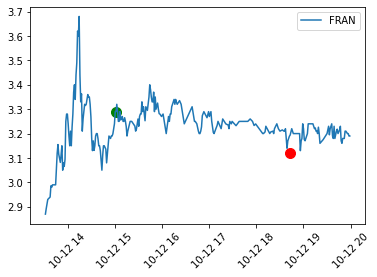

FTK analysis with profit $37.32


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3470.76,-3470.76,buy,2020-10-12 11:06:29.029495-04:00,2.79,1244,3.72%,,"{'buy': {'avg': 2.7154, 'macd': [0.014350960453040518, 0.014475475332575094, 0.014408067043520045, 0.014988780582938066, 0.016070664061594186], 'vwap': 2.7873, 'macd_signal': [0.012966777227444262, 0.013268516848470429, 0.013496426887480352, 0.013794897626571895, 0.014250050913576354]}, 'sell': None}",3.02,2.71
1,37.32,3508.08,sell,2020-10-12 11:48:27.945665-04:00,2.82,1244,4.83%,,"{'buy': None, 'sell': {'avg': 2.7641, 'rsi': [59.174407507874385, 61.764081915347866, 61.764081915347866], 'vwap': 2.8352, 'reasons': 'bail', 'movement': 0.02150537634408604, 'sell_macd': [0.013791093831433177, 0.01258923125218514, 0.0118476600053401, 0.01163542708565135, 0.010550110173093152], 'sell_macd_signal': [0.013250994066213575, 0.013118641503407889, 0.01286444520379433, 0.012618641580165735, 0.012204935298751218]}}",3.02,2.71


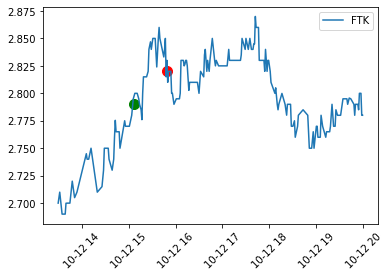

GME analysis with profit $-95.15


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2165.96,-2165.96,buy,2020-10-12 10:30:03.684192-04:00,12.52,173,6.38%,,"{'buy': {'avg': 12.1342, 'macd': [0.028070009110118477, 0.03277613031852589, 0.039296582771624955, 0.04682119272466245, 0.052932825106960735], 'vwap': 12.521, 'macd_signal': [0.05238685995056434, 0.048464714024156655, 0.04663108777365031, 0.04666910876385274, 0.04792185203247434]}, 'sell': None}",14.16,11.98
1,-95.15,2070.81,sell,2020-10-12 11:40:58.819251-04:00,11.97,173,1.71%,,"{'buy': None, 'sell': {'avg': 12.1863, 'rsi': [39.162730834936255, 37.6021554368442, 31.597212363656162], 'vwap': 11.9704, 'reasons': 'stopped', 'movement': -0.04472044728434497, 'sell_macd': [-0.03318712203187424, -0.032894875032837945, -0.033180203669525454, -0.03402617139071751, -0.03837853362293586], 'sell_macd_signal': [-0.028751443022162128, -0.029580129424297292, -0.030300144273342926, -0.031045349696817843, -0.03251198648204145]}}",14.16,11.98


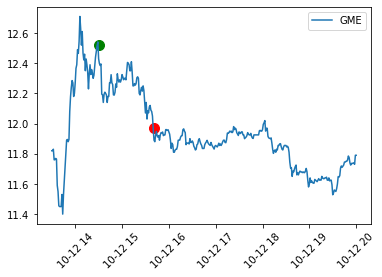

GPRO analysis with profit $31.22


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2925.76,-2925.76,buy,2020-10-12 11:09:54.116716-04:00,6.56,446,5.3%,,"{'buy': {'avg': 6.4477, 'macd': [0.0053534723087311775, 0.0063944961318664895, 0.006554905154187551, 0.008201323560231621, 0.010985254521545862], 'vwap': 6.5699, 'macd_signal': [0.005372585560788508, 0.005576967675004104, 0.005772555170840793, 0.006258308848718959, 0.00720369798328434]}, 'sell': None}",7.2,6.36
1,31.22,2956.98,sell,2020-10-12 12:20:56.261251-04:00,6.63,446,6.42%,,"{'buy': None, 'sell': {'avg': 6.4666, 'rsi': [70.66489568242139, 75.12649100700895, 79.35358486702425], 'vwap': 6.6218, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.009908536585365915, 'sell_macd': [0.0026755772990902926, 0.0035988894166463226, 0.0055703158794617735, 0.008073111618285722, 0.011050963991158014], 'sell_macd_signal': [0.0012049438445806164, 0.0016837329589937575, 0.0024610495430873605, 0.003583461958127033, 0.005076962364733229]}}",7.2,6.36


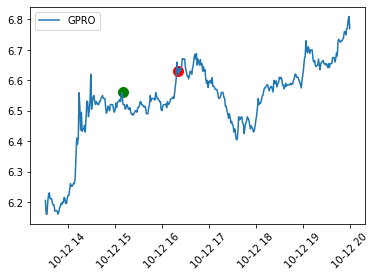

HYRE analysis with profit $18.52


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1935.34,-1935.34,buy,2020-10-12 09:50:31.915159-04:00,4.18,463,3.21%,,"{'buy': {'avg': 4.1004, 'macd': [0.03425061965870846, 0.03900725760099277, 0.03510995390789873, 0.037240442992706235, 0.0424738410734804], 'vwap': 4.18, 'macd_signal': [0.027740975667042138, 0.029994232053832264, 0.031017376424645558, 0.032261989738257696, 0.03430436000530224]}, 'sell': None}",4.79,3.98
1,-1585.08,350.26,sell,2020-10-12 10:12:41.166151-04:00,4.22,83,4.2%,,"{'buy': None, 'sell': {'avg': 4.2196, 'rsi': [64.24753942893356, 60.953945835162, 59.48804264245625], 'vwap': 4.2863, 'reasons': 'bail', 'movement': 0.025430622009569394, 'sell_macd': [0.035865536450468305, 0.03581551140558492, 0.03635035537832998, 0.035084644767763074, 0.03310247228202634], 'sell_macd_signal': [0.03406155794434217, 0.03441234863659072, 0.03479994998493857, 0.034856888941503475, 0.03450600560960805]}}",4.79,3.98
2,18.52,1603.60,sell,2020-10-12 10:12:41.322195-04:00,4.22,380,4.2%,,"{'buy': None, 'sell': {'avg': 4.2196, 'rsi': [64.24753942893356, 60.953945835162, 59.48804264245625], 'vwap': 4.2863, 'reasons': 'bail', 'movement': 0.025430622009569394, 'sell_macd': [0.035865536450468305, 0.03581551140558492, 0.03635035537832998, 0.035084644767763074, 0.03310247228202634], 'sell_macd_signal': [0.03406155794434217, 0.03441234863659072, 0.03479994998493857, 0.034856888941503475, 0.03450600560960805]}}",4.79,3.98


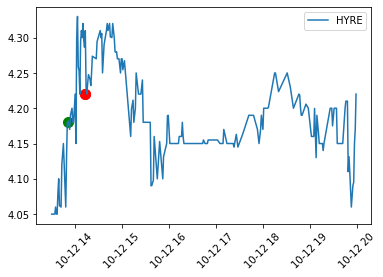

IH analysis with profit $29.82


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-831.18,-831.18,buy,2020-10-12 10:22:32.206345-04:00,19.79,42,24.62%,,"{'buy': {'avg': 17.4301, 'macd': [0.36075200395064755, 0.36289576960692926, 0.3955395088577838, 0.40145082013571454, 0.44826964441174866], 'vwap': 19.8431, 'macd_signal': [0.40281161520611247, 0.3948284460862758, 0.3949706586405774, 0.3962666909396048, 0.4066672816340336]}, 'sell': None}",26.54,17.6
1,29.82,861.00,sell,2020-10-12 11:49:05.833517-04:00,20.50,42,29.09%,,"{'buy': None, 'sell': {'avg': 18.2713, 'rsi': [73.653467600415, 76.92203025425194, 79.3862040106228], 'vwap': 20.67, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.04446690247599811, 'sell_macd': [0.053654611908633854, 0.062083354946839364, 0.08654622802924905, 0.11435435993724141, 0.14336908142480453], 'sell_macd_signal': [0.03930249045797435, 0.043858663355747354, 0.052396176290447696, 0.06478781301980643, 0.08050406670080605]}}",26.54,17.6


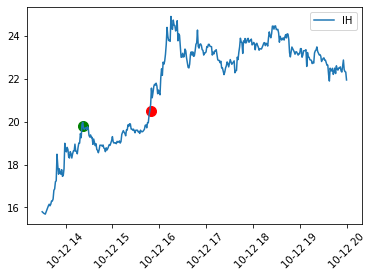

INTZ analysis with profit $20.15


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1588.75,-1588.75,buy,2020-10-12 10:13:52.089855-04:00,10.25,155,4.38%,,"{'buy': {'avg': 9.9283, 'macd': [0.06401284070834912, 0.06297688482286468, 0.06623387796303781, 0.06803085118724006, 0.08860647577956726], 'vwap': 10.25, 'macd_signal': [0.07054937153321617, 0.06903487419114587, 0.06847467494552426, 0.06838591019386742, 0.07243002331100738]}, 'sell': None}",12.07,9.64
1,20.15,1608.90,sell,2020-10-12 10:52:11.805675-04:00,10.38,155,5.7%,,"{'buy': None, 'sell': {'avg': 10.0538, 'rsi': [69.03401018709663, 74.52350240815909, 79.4149523148298], 'vwap': 10.4949, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.024390243902439025, 'sell_macd': [0.03427078194790134, 0.034763433581794345, 0.037293247405845165, 0.04340877444528779, 0.05310647376894018], 'sell_macd_signal': [0.031026701510441675, 0.03177404792471221, 0.0328778878209388, 0.034984065145808596, 0.03860854687043491]}}",12.07,9.64


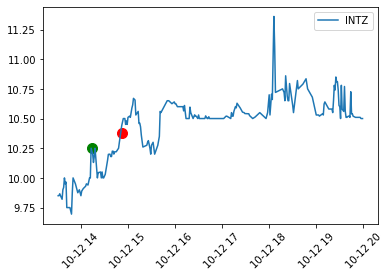

JMIA analysis with profit $79.36


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-238.77,-238.77,buy,2020-10-12 11:26:49.004835-04:00,11.37,21,3.55%,,"{'buy': {'avg': 11.1261, 'macd': [0.026007533209845946, 0.024985546776315815, 0.022703528382225002, 0.023073986581929162, 0.02788760498247278], 'vwap': 11.3611, 'macd_signal': [0.025780434862834916, 0.025621457245531096, 0.02503787147286988, 0.024645094494681736, 0.025293596592239946]}, 'sell': None}",12.47,11.0
1,-2910.72,-2671.95,buy,2020-10-12 11:26:49.182242-04:00,11.37,235,3.55%,,"{'buy': {'avg': 11.1261, 'macd': [0.026007533209845946, 0.024985546776315815, 0.022703528382225002, 0.023073986581929162, 0.02788760498247278], 'vwap': 11.3611, 'macd_signal': [0.025780434862834916, 0.025621457245531096, 0.02503787147286988, 0.024645094494681736, 0.025293596592239946]}, 'sell': None}",12.47,11.0
2,79.36,2990.08,sell,2020-10-12 11:36:26.821490-04:00,11.68,256,6.38%,,"{'buy': None, 'sell': {'avg': 11.1701, 'rsi': [68.35163982702188, 72.09858406942018, 79.02361026002916], 'vwap': 11.7, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.03034300791556734, 'sell_macd': [0.03960910128570028, 0.043012032899302, 0.044273901261858484, 0.04759128048902106, 0.05631142949084911], 'sell_macd_signal': [0.026360456419920814, 0.02969077171579705, 0.03260739762500934, 0.035604174197811686, 0.03974562525641917]}}",12.47,11.0


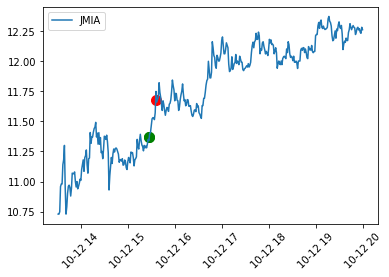

LEVI analysis with profit $-94.86


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3024.36,-3024.36,buy,2020-10-12 11:07:17.048743-04:00,16.26,186,2.72%,,"{'buy': {'avg': 16.1477, 'macd': [-0.023593076335956198, -0.016549979454197228, -0.013236442245361246, -0.006102059050459019, 0.0007536777438446052], 'vwap': 16.26, 'macd_signal': [-0.019643001398756993, -0.01902439700984504, -0.017866806056948282, -0.01551385665565043, -0.012260349775751422]}, 'sell': None}",17.78,15.75
1,-94.86,2929.50,sell,2020-10-12 13:21:28.279747-04:00,15.75,186,-0.51%,,"{'buy': None, 'sell': {'avg': 16.1217, 'rsi': [39.881712023062086, 32.438243290685996, 29.475974673785483], 'vwap': 15.7507, 'reasons': 'stopped', 'movement': -0.03136531365313663, 'sell_macd': [-0.012471341750915244, -0.012070941259564094, -0.011861915665530631, -0.013622909804393402, -0.015820789525529122], 'sell_macd_signal': [-0.013982200950545027, -0.01359994901234884, -0.0132523423429852, -0.01332645583526684, -0.013825322573319296]}}",17.78,15.75


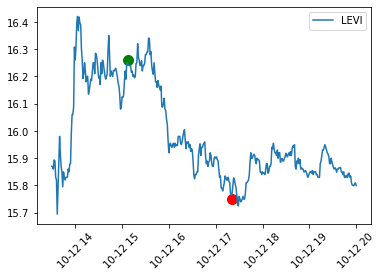

LPTX analysis with profit $-61.26


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2256.41,-2256.41,buy,2020-10-12 11:14:29.180108-04:00,2.21,1021,5.24%,,"{'buy': {'avg': 2.1476, 'macd': [0.009920784750036216, 0.011520591175381956, 0.012642711979566013, 0.0133777899659826, 0.014598973118121528], 'vwap': 2.2097, 'macd_signal': [0.009277413149936922, 0.009726048755025928, 0.010309381399933945, 0.010923063113143675, 0.011658245114139246]}, 'sell': None}",2.49,2.12
1,-61.26,2195.15,sell,2020-10-12 15:49:39.769210-04:00,2.15,1021,2.38%,,"{'buy': None, 'sell': {'liquidation': 1}}",2.49,2.12


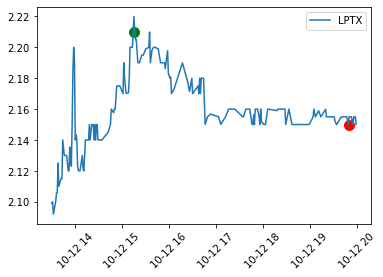

MARA analysis with profit $11.04


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1291.68,-1291.68,buy,2020-10-12 09:50:12.933377-04:00,2.34,552,4.23%,,"{'buy': {'avg': 2.2493, 'macd': [0.01974907815475424, 0.021807189919388126, 0.024367736858410094, 0.029287051561536437, 0.03284734596926775], 'vwap': 2.3307, 'macd_signal': [0.022212121924619972, 0.022131135523573604, 0.0225784557905409, 0.023920174944740007, 0.025705609149645557]}, 'sell': None}",2.84,2.16
1,11.04,1302.72,sell,2020-10-12 10:04:12.974748-04:00,2.36,552,5.12%,,"{'buy': None, 'sell': {'avg': 2.2958, 'rsi': [65.00856019003052, 64.97962996901, 64.54655112876114], 'vwap': 2.3686, 'reasons': 'bail post whipsawed', 'movement': 0.012222222222222206, 'sell_macd': [0.02506528754853843, 0.02472759005758496, 0.02415370123271776, 0.023387635898630244, 0.022414239068190067], 'sell_macd_signal': [0.021463150903873567, 0.022116038734615845, 0.022523571234236227, 0.02269638416711503, 0.022639955147330037]}}",2.84,2.16


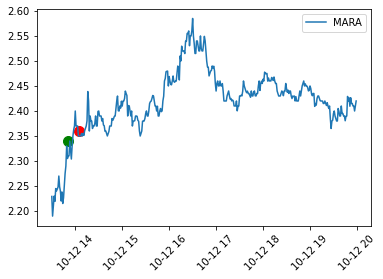

MTA analysis with profit $11.04


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3231.04,-3231.04,buy,2020-10-12 11:13:33.208254-04:00,8.78,368,2.43%,,"{'buy': {'avg': 8.6318, 'macd': [0.009741737622670499, 0.011628587461880002, 0.012176648304999205, 0.012866135879466611, 0.015254012060264444], 'vwap': 8.78, 'macd_signal': [0.011108805149250897, 0.011212761611776718, 0.011405538950421215, 0.011697658336230295, 0.012408929081037124]}, 'sell': None}",9.55,8.52
1,11.04,3242.08,sell,2020-10-12 13:29:51.651495-04:00,8.81,368,2.78%,,"{'buy': None, 'sell': {'avg': 8.6735, 'rsi': [49.17297020748364, 46.50790484072763, 46.50790484072763], 'vwap': 8.81, 'reasons': 'bail post whipsawed', 'movement': 0.0034168564920274646, 'sell_macd': [0.011828396897016091, 0.009768683759462604, 0.00777710620085692, 0.00560474568504965, 0.003839208326173349], 'sell_macd_signal': [0.014893114155498913, 0.013868228076291652, 0.012650003701204705, 0.011240952097973694, 0.009760603343613625]}}",9.55,8.52


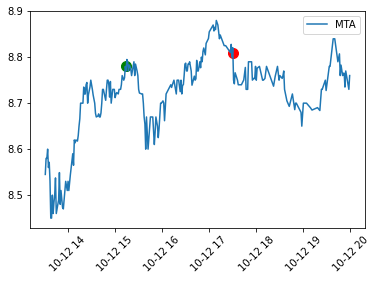

ONVO analysis with profit $85.76


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1407.00,-1407.00,buy,2020-10-12 11:02:37.446301-04:00,10.50,134,13.76%,,"{'buy': {'avg': 10.1129, 'macd': [0.04023587797400374, 0.048278749675032984, 0.05402995970090885, 0.06470079422601493, 0.08149759285137215], 'vwap': 10.4868, 'macd_signal': [0.08109126475954202, 0.07452876174264021, 0.07042900133429394, 0.06928335991263815, 0.07172620650038494]}, 'sell': None}",12.6,9.8
1,-674.69,732.31,sell,2020-10-12 11:26:24.796303-04:00,10.93,67,18.42%,,"{'buy': None, 'sell': {'avg': 10.2516, 'rsi': [77.82536910596441, 63.3416271665784, 68.64408827178072], 'vwap': 10.925, 'reasons': 'scale-out', 'movement': 0.04047619047619054, 'sell_macd': [0.08463971390039582, 0.08463178797597237, 0.09131870559361488, 0.0870316452230302, 0.08957378460669041], 'sell_macd_signal': [0.07721289920538668, 0.07869667695950382, 0.08122108268632602, 0.08238319519366685, 0.08382131307627157]}}",12.6,9.8
2,85.76,760.45,sell,2020-10-12 11:28:05.826515-04:00,11.35,67,22.97%,,"{'buy': None, 'sell': {'avg': 10.3271, 'rsi': [74.75299528031356, 79.39725599763364, 80.4297281149014], 'vwap': 11.42, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.04483074107959746, 'sell_macd': [0.0870316452230302, 0.08957378460669041, 0.10128488302763827, 0.12079892227736977, 0.13755273309173965], 'sell_macd_signal': [0.08238319519366685, 0.08382131307627157, 0.08731402706654491, 0.09401100610870988, 0.10271935150531583]}}",12.6,9.8


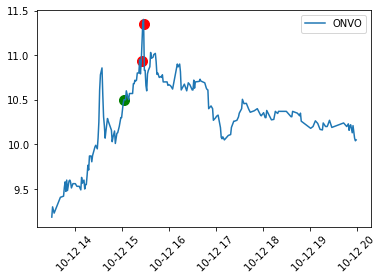

PLT analysis with profit $5.2


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2220.4,-2220.4,buy,2020-10-12 11:05:30.334415-04:00,17.08,130,7.69%,,"{'buy': {'avg': 16.1794, 'macd': [0.07308436904571636, 0.0727939909910944, 0.07732097125039772, 0.08233987633958506, 0.08936221079590823], 'vwap': 17.0767, 'macd_signal': [0.08014524130471687, 0.07867499124199237, 0.07840418724367344, 0.07919132506285577, 0.08122550220946625]}, 'sell': None}",19.24,16.36
1,5.2,2225.6,sell,2020-10-12 11:53:46.373982-04:00,17.12,130,7.94%,,"{'buy': None, 'sell': {'avg': 16.4005, 'rsi': [54.575296864151866, 48.774985821107485, 50.883136988531284], 'vwap': 17.115, 'reasons': 'bail post whipsawed', 'movement': 0.002049180327868861, 'sell_macd': [0.012976985984792577, 0.013482005278053322, 0.012765370892569905, 0.009963248372805822, 0.008429604222694564], 'sell_macd_signal': [0.008066107855127548, 0.009149287339712703, 0.009872504050284144, 0.009890652914788479, 0.009598443176369697]}}",19.24,16.36


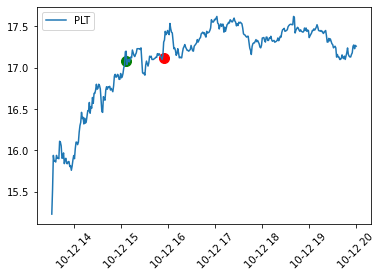

PPSI analysis with profit $-103.04


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1059.52,-1059.52,buy,2020-10-12 09:50:30.188734-04:00,4.73,224,3.84%,,"{'buy': {'avg': 4.565, 'macd': [0.01626071579134436, 0.022769349723722243, 0.026803529018620154, 0.0332564782779432, 0.04032637894233648], 'vwap': 4.7098, 'macd_signal': [0.008388332749062703, 0.01126453614399461, 0.01437233471891972, 0.018149163430724417, 0.02258460653304683]}, 'sell': None}",5.97,4.3
1,-103.04,956.48,sell,2020-10-12 12:59:47.265599-04:00,4.27,224,-6.26%,,"{'buy': None, 'sell': {'avg': 4.5844, 'rsi': [37.55126087266865, 33.171834284410465, 16.244892396831663], 'vwap': 4.2631, 'reasons': 'stopped', 'movement': -0.09302325581395356, 'sell_macd': [-0.014620804739391424, -0.01546247954731772, -0.015351284858074798, -0.016327609972195845, -0.028746465775768115], 'sell_macd_signal': [-0.012967661161535336, -0.013466624838691812, -0.013843556842568409, -0.014340367468493896, -0.01722158712994874]}}",5.97,4.3


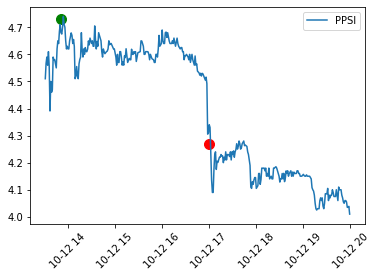

PRTS analysis with profit $20.5


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2539.95,-2539.95,buy,2020-10-12 11:18:15.865957-04:00,12.39,205,12.07%,,"{'buy': {'avg': 11.9938, 'macd': [0.02867792881372111, 0.028585567719693117, 0.030349266945513875, 0.03337952398061006, 0.03816528634166261], 'vwap': 12.3721, 'macd_signal': [0.022735683681220066, 0.023905660488914675, 0.025194381780234514, 0.026831410220309625, 0.029098185444580222]}, 'sell': None}",13.76,11.93
1,20.50,2560.45,sell,2020-10-12 11:22:51.158073-04:00,12.49,205,12.98%,,"{'buy': None, 'sell': {'avg': 12.0099, 'rsi': [74.50651280264087, 77.06429616623221, 79.09084598791132], 'vwap': 12.53, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.01129943502824849, 'sell_macd': [0.023505078735494678, 0.02859933679038562, 0.03279487116055435, 0.03755509442093974, 0.04249611131966802], 'sell_macd_signal': [0.017847976211204684, 0.01999824832704087, 0.022557572893743567, 0.0255570771991828, 0.028944884023279844]}}",13.76,11.93


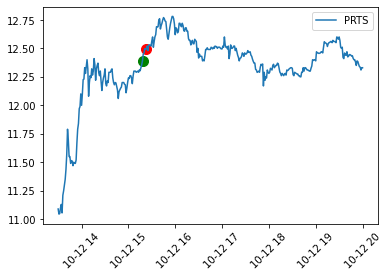

PRTY analysis with profit $69.52


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2328.92,-2328.92,buy,2020-10-12 10:29:09.057472-04:00,2.68,869,4.28%,,"{'buy': {'avg': 2.6149, 'macd': [0.003285313211720098, 0.003726736017165333, 0.005601620140894603, 0.006631781546769133, 0.0085598933998412], 'vwap': 2.6701, 'macd_signal': [0.005384326389345743, 0.0050528083149096615, 0.00516257068010665, 0.0054564128534391465, 0.006077108962719557]}, 'sell': None}",3.01,2.57
1,69.52,2398.44,sell,2020-10-12 10:34:10.822767-04:00,2.76,869,7.39%,,"{'buy': None, 'sell': {'avg': 2.648, 'rsi': [73.73593660088878, 78.79167939427325, 79.49996921389965], 'vwap': 2.7522, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.027985074626865572, 'sell_macd': [0.00841938004255427, 0.010069138688915125, 0.011686234534275641, 0.014352981497747663, 0.016358849501781236], 'sell_macd_signal': [0.004387410045279668, 0.005523755774006759, 0.006756251526060535, 0.00827559752039796, 0.009892247916674615]}}",3.01,2.57


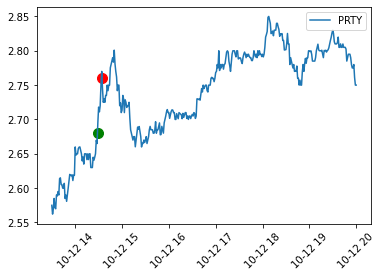

RIOT analysis with profit $48.87


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1775.61,-1775.61,buy,2020-10-12 09:50:16.301569-04:00,3.27,543,1.08%,,"{'buy': {'avg': 3.2169, 'macd': [0.022352385789148332, 0.025027015874484082, 0.02603959482026541, 0.028530480378125223, 0.031201909457609478], 'vwap': 3.2683, 'macd_signal': [0.02838089028272915, 0.02771011540108014, 0.027376011284917193, 0.027606905103558798, 0.028325905974368935]}, 'sell': None}",3.79,3.09
1,48.87,1824.48,sell,2020-10-12 10:06:22.896021-04:00,3.36,543,3.86%,,"{'buy': None, 'sell': {'avg': 3.2634, 'rsi': [71.41903962543806, 71.41903962543806, 65.14043366503724], 'vwap': 3.3608, 'reasons': 'bail', 'movement': 0.027767584097859257, 'sell_macd': [0.03225629165153787, 0.033209343953858994, 0.03253887374847464, 0.03159384665663678, 0.029449749615507947], 'sell_macd_signal': [0.027498662410933846, 0.028640798719518877, 0.02942041372531003, 0.02985510031157538, 0.029774030172361892]}}",3.79,3.09


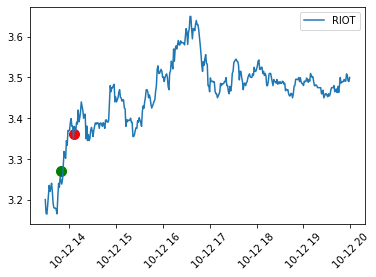

RVP analysis with profit $24.8


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1416.7,-1416.7,buy,2020-10-12 11:02:14.631785-04:00,9.14,155,5.35%,,"{'buy': {'avg': 8.9652, 'macd': [0.019743118130724824, 0.01926965722577023, 0.04939136555122303, 0.06967599326431362, 0.08553231419890928], 'vwap': 9.15, 'macd_signal': [0.03107221368606879, 0.028711702394009078, 0.03284763502545187, 0.04021330667322422, 0.04927710817836123]}, 'sell': None}",10.97,8.54
1,24.8,1441.5,sell,2020-10-12 11:09:40.009268-04:00,9.30,155,7.19%,,"{'buy': None, 'sell': {'avg': 9.027, 'rsi': [76.69843063293331, 76.19602556762206, 79.14532247178175], 'vwap': 9.366, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.025164113785557836, 'sell_macd': [0.06973813172599286, 0.0740289272101009, 0.08043696359758634, 0.08416742099565866, 0.09014742129291342], 'sell_macd_signal': [0.04698377669085645, 0.05239280679470534, 0.058001638155281546, 0.06323479472335697, 0.06861732003726825]}}",10.97,8.54


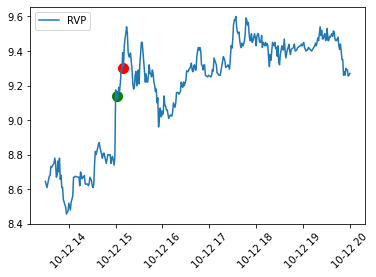

SCO analysis with profit $0.0


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3707.67,-3707.67,buy,2020-10-12 11:05:31.033415-04:00,16.93,219,2.67%,,"{'buy': {'avg': 16.8099, 'macd': [0.01065264688166323, 0.007751341089534236, 0.009378507878153641, 0.011344196867778322, 0.015156127593346724], 'vwap': 16.9301, 'macd_signal': [0.0020936381112051866, 0.0032251787068709966, 0.004455844541127525, 0.005833515006457684, 0.007698037523835492]}, 'sell': None}",18.22,16.5
1,0.00,3707.67,sell,2020-10-12 13:05:15.521655-04:00,16.93,219,2.67%,,"{'buy': None, 'sell': {'avg': 16.8207, 'rsi': [71.95640013472901, 71.07561837857513, 63.318151040566065], 'vwap': 16.9304, 'reasons': 'bail post whipsawed', 'movement': 0.00014766686355589361, 'sell_macd': [0.02234067296129183, 0.022198167455314888, 0.021798836314872005, 0.021116255733815592, 0.019380267544242713], 'sell_macd_signal': [0.018603671028240475, 0.019322570313655356, 0.019817823513898686, 0.020077509957882066, 0.019938061475154194]}}",18.22,16.5


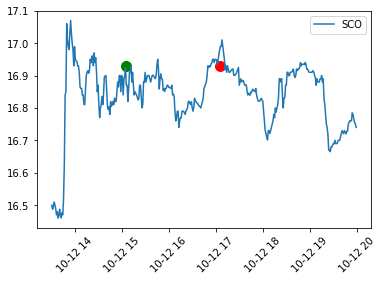

TBIO analysis with profit $-14.19


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2040.78,-2040.78,buy,2020-10-12 10:07:57.855817-04:00,15.82,129,2.39%,,"{'buy': {'avg': 15.4006, 'macd': [0.09396925451377314, 0.10079298604120801, 0.10379399523174904, 0.10456351530716645, 0.11594062060491872], 'vwap': 15.82, 'macd_signal': [0.1015535244368827, 0.10140141675774776, 0.10187993245254802, 0.10241664902347171, 0.10512144333976112]}, 'sell': None}",18.0,15.09
1,-14.19,2026.59,sell,2020-10-12 12:02:14.042788-04:00,15.71,129,1.68%,,"{'buy': None, 'sell': {'avg': 15.5062, 'rsi': [72.6005324376733, 73.62765009178214, 81.21231034081734], 'vwap': 15.7544, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.0012642225031605293, 'sell_macd': [0.010582156623575756, 0.013116068419243732, 0.01751760918964429, 0.021239360319961875, 0.026689564313455705], 'sell_macd_signal': [0.001154865484397181, 0.0035471060713664912, 0.0063412066950220515, 0.009320837420010017, 0.012794582798699154]}}",18.0,15.09


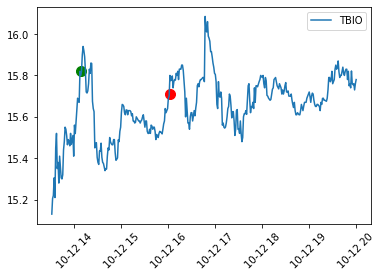

TCON analysis with profit $34.32


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1484.34,-1484.34,buy,2020-10-12 11:21:32.130066-04:00,5.19,286,4.25%,,"{'buy': {'avg': 5.0628, 'macd': [0.02123531569555226, 0.020292509535792647, 0.028065610014206044, 0.03465746241166112, 0.0426259226955743], 'vwap': 5.19, 'macd_signal': [0.004125283971459389, 0.0073587290843260406, 0.011500105270302041, 0.016131576698573857, 0.021430445897973945]}, 'sell': None}",6.18,4.86
1,34.32,1518.66,sell,2020-10-12 12:06:40.889328-04:00,5.31,286,6.66%,,"{'buy': None, 'sell': {'avg': 5.1443, 'rsi': [62.37225681721954, 64.58540153497798, 56.26905241914864], 'vwap': 5.31, 'reasons': 'bail', 'movement': 0.02312138728323684, 'sell_macd': [0.025549252163574288, 0.026102430155519052, 0.02475552430306749, 0.024163707738779294, 0.021570555769998556], 'sell_macd_signal': [0.02211725494618192, 0.022914289988049348, 0.023282536851052978, 0.02345877102859824, 0.023081127976878304]}}",6.18,4.86


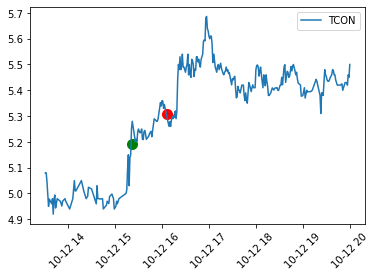

TLRY analysis with profit $6.76


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2183.48,-2183.48,buy,2020-10-12 11:18:59.794559-04:00,6.46,338,2.7%,,"{'buy': {'avg': 6.3125, 'macd': [0.005445450542209684, 0.008720532754032284, 0.011976844654986607, 0.014678777401831766, 0.01698737112198856], 'vwap': 6.4691, 'macd_signal': [0.008489547097110837, 0.008535744228495127, 0.009223964313793423, 0.010314926931401092, 0.011649415769518586]}, 'sell': None}",7.3,6.19
1,6.76,2190.24,sell,2020-10-12 11:44:26.179381-04:00,6.48,338,3.02%,,"{'buy': None, 'sell': {'avg': 6.3305, 'rsi': [56.5017505748984, 49.0976622846067, 51.65605787390818], 'vwap': 6.4605, 'reasons': 'bail post whipsawed', 'movement': 0.0007739938080495191, 'sell_macd': [0.021315031222409075, 0.01924703214729817, 0.017905123359584607, 0.014549024000852562, 0.012290387825205862], 'sell_macd_signal': [0.012735960390380791, 0.014038174741764267, 0.014811564465328334, 0.01475905637243318, 0.014265322662987715]}}",7.3,6.19


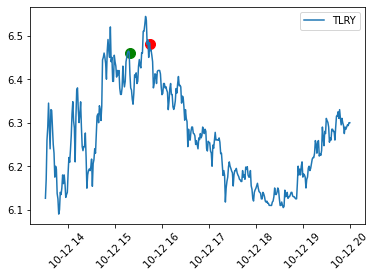

UBX analysis with profit $68.24


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3429.06,-3429.06,buy,2020-10-12 11:21:32.435588-04:00,4.02,853,3.78%,,"{'buy': {'avg': 3.9528, 'macd': [0.004073326632948238, 0.0031087254613981763, 0.003378525392959464, 0.0035992686397041673, 0.004927779518040243], 'vwap': 4.02, 'macd_signal': [0.005290115066613331, 0.0048538371455703, 0.004558774795048133, 0.00436687356397934, 0.004479054754791521]}, 'sell': None}",4.35,3.91
1,68.24,3497.30,sell,2020-10-12 12:22:42.158695-04:00,4.10,853,5.85%,,"{'buy': None, 'sell': {'avg': 3.9951, 'rsi': [52.356527613748405, 54.36094217304351, 54.005040182891825], 'vwap': 4.1092, 'reasons': 'bail', 'movement': 0.022189054726368368, 'sell_macd': [0.0063016785301934775, 0.005846698211487755, 0.005130522661697334, 0.004791547913007399, 0.004423625408664478], 'sell_macd_signal': [0.003942750619430516, 0.004323540137841963, 0.0044849366426130376, 0.00454625889669191, 0.004521732199086423]}}",4.35,3.91


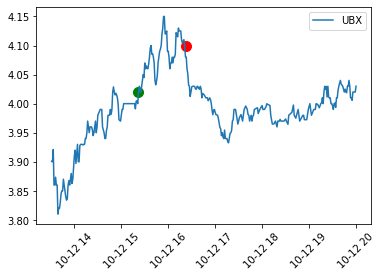

VNE analysis with profit $-14.7


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3864.0,-3864.0,buy,2020-10-12 11:30:12.008994-04:00,18.40,210,0.71%,,"{'buy': {'avg': 18.3018, 'macd': [-0.002271087611795508, -0.003162607048995625, -0.002229608237126257, -0.0014732176211360581, 0.002327068105021368], 'vwap': 18.4, 'macd_signal': [-0.003127639555561688, -0.0031346330542484755, -0.0029536280908240317, -0.002657545996886437, -0.001660623176504876]}, 'sell': None}",19.74,17.95
1,-14.7,3849.3,sell,2020-10-12 15:47:56.216024-04:00,18.33,210,0.33%,,"{'buy': None, 'sell': {'liquidation': 1}}",19.74,17.95


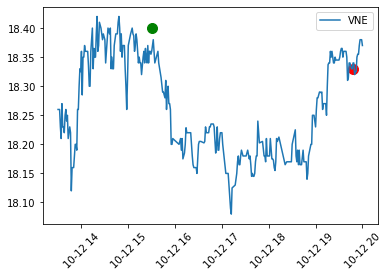

WVE analysis with profit $-66.15


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2822.40,-2822.40,buy,2020-10-12 11:04:14.678764-04:00,8.96,315,5.16%,,"{'buy': {'avg': 8.7536, 'macd': [0.01931350679663346, 0.018461835039429886, 0.018916373291885336, 0.019320169662989883, 0.022607244658436443], 'vwap': 8.96, 'macd_signal': [0.02011391084525715, 0.019783495684091698, 0.019610071205650427, 0.01955209089711832, 0.020163121649381943]}, 'sell': None}",9.86,8.66
1,-66.15,2756.25,sell,2020-10-12 15:47:10.248563-04:00,8.75,315,2.7%,,"{'buy': None, 'sell': {'liquidation': 1}}",9.86,8.66


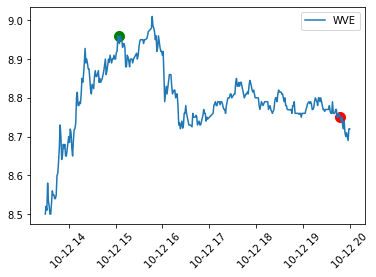

In [8]:
est = pytz.timezone("US/Eastern")
position = {}
for symbol in minute_history:
    symbol_df = trades.loc[trades["symbol"] == symbol]
    start_date = symbol_df["tstamp"].min().to_pydatetime()
    start_date = start_date.replace(hour=9, minute=30)
    cool_down_date = start_date + timedelta(minutes=5)
    try:
        minute_history_index = minute_history[symbol]["close"].index.get_loc(
            start_date, method="nearest"
        )
    except Exception as e:
        print(f"Error for {symbol}: {e}")
        continue

    cool_minute_history_index = minute_history[symbol]["close"].index.get_loc(
        cool_down_date, method="nearest"
    )
    open_price = minute_history[symbol]["close"][cool_minute_history_index]
    plt.plot(
        minute_history[symbol]["close"][minute_history_index:].between_time(
            "9:30", "16:00"
        ),
        label=symbol,
    )
    plt.xticks(rotation=45)

    delta = 0
    profit = 0

    operations = []
    deltas = []
    profits = []
    times = []
    prices = []
    qtys = []
    indicators = []
    target_price = []
    stop_price = []
    daily_change = []
    precent_vwap = []
    position[symbol] = 0
    for index, row in symbol_df.iterrows():
        if not position[symbol]:
            try:
                now = int(row["client_time"])
                continue
            except Exception:
                pass

        if position[symbol] >= 0 and row["operation"] == "buy":
            delta = -row["price"] * row["qty"]
            position[symbol] += row["qty"]
        elif position[symbol] <= 0 and row["operation"] == "sell":
            delta = row["price"] * row["qty"]
            position[symbol] -= row["qty"]
        elif position[symbol] > 0 and row["operation"] == "sell":
            delta = row["price"] * row["qty"]
            position[symbol] -= row["qty"]
        elif position[symbol] < 0 and row["operation"] == "buy":
            delta = -row["price"] * row["qty"]
            position[symbol] += row["qty"]

        profit += delta
        plt.scatter(
            row["tstamp"].to_pydatetime(),
            row["price"],
            c="g" if row["operation"] == "buy" else "r",
            s=100,
        )
        deltas.append(round(delta, 2))
        profits.append(round(profit, 2))
        operations.append(row["operation"])
        times.append(pytz.utc.localize(pd.to_datetime(row["tstamp"])).astimezone(est))
        prices.append(row["price"])
        qtys.append(row["qty"])
        indicators.append(row["indicators"])
        target_price.append(row["target_price"])
        stop_price.append(row["stop_price"])
        daily_change.append(
            f"{round(100.0 * (row['price'] - open_price) / open_price, 2)}%"
        )
        precent_vwap.append(
            f"{round(100.0 * (row['indicators']['avg'] - open_price) / open_price, 2)}%"
            if "avg" in row["indicators"]
            else ""
        )

    d = {
        "profit": profits,
        "trade": deltas,
        "operation": operations,
        "at": times,
        "price": prices,
        "qty": qtys,
        "daily change": daily_change,
        "vwap": precent_vwap,
        "indicators": indicators,
        "target price": target_price,
        "stop price": stop_price,
    }
    print(f"{symbol} analysis with profit ${round(profit, 2)}")
    display(HTML(pd.DataFrame(data=d).to_html()))
    plt.legend()
    plt.show()